In [42]:
import os
import sys
import pickle
import string
import warnings

import numpy as np
import matplotlib.pyplot as plt

# Visualization tool for the elbow method to determine the optimal number of clusters
from yellowbrick.cluster.elbow import kelbow_visualizer

from sklearn.cluster import KMeans, SpectralClustering, HDBSCAN, AgglomerativeClustering

from utils import get_defect_arr_from_frame, get_clustering
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [34]:
path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\cluster_zeta_0.022'
d_cluster = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\cluster_zeta_0.022', \
              suffix = "cluster", priority = -1, LX = 512, Nframes = 1500)
output_path = 'cl_exp512' 
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [78]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

LL = 512
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)
conv_list = ad.conv_list[-1]


In [36]:
def_path = os.path.join(path, os.listdir(path)[0])
uni_path = "data/na512cl/uni/cluster_arr_uni.npy"
cl_uni = np.load(uni_path)
with open(os.path.join(def_path, 'defect_positions.pkl'), 'rb') as f:
        defect_positions = pickle.load(f)

In [37]:
cl_uni.shape

(4, 10, 75000)

In [88]:
def do_clustering(defect_list, method, method_kwargs, LX, Ncmin = 2, save = False, save_path = None,):
    """
    This function is an improved version of do_poisson_clustering. It allows for Ndefects to vary for each activity,
    and also allows for Ntrial to be bigger than the number of defect entries in def_arr. For each run, it randomly selects
    Ndefects from the given column in def_arr, simulates points uniformly and performs the clustering.

    Parameters:
        def_arr: array of defect entries for each activity. Format (Ndefect_entries, Nactivities)
        Ncmin: minimum number of defects in a cluster
        method: clustering method
        method_kwargs: dictionary of arguments for method

    Returns: cluster_arr, cl_mean, cl_std

    """
    
    Nframes = len(defect_list)
    cluster_arr = np.nan * np.zeros([Nframes, 4])


    labels = get_clustering(defect_list, method, method_kwargs)

    for j in range(Nframes):

        # N = np.random.choice(def_arr[:, i], size = 1)[0]
        N = len(labels[j])

        if N == 0:
            continue

        counts = np.unique(labels[j], return_counts=True)[1]

        # Only count clusters with more than Ncmin defects
        mask = (counts >= Ncmin)
        counts_above_min = counts[mask]

        # store the total number of defects
        cluster_arr[j, 0] = N

        # store the fraction of clustered defects
        cluster_arr[j, 1] = counts_above_min.sum() / N

        # store the number of clusters
        cluster_arr[j, 2] = len(counts_above_min)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)

            # store the average cluster size
            cluster_arr[j, 3] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(Nframes)

    if save:
        if save_path is None:
            save_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\na{LX}cl\\uni'
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'cluster_arr_uni.npy'), cluster_arr)
        np.save(os.path.join(save_path, 'cl_mean_uni.npy'), cl_mean)
        np.save(os.path.join(save_path, 'cl_std_uni.npy'), cl_std)
    return cluster_arr, cl_mean, cl_std



def gen_poisson_clustering(defect_arr_flat, L, Ntrial, use_grid = True, Ncmin = 2, method = None, method_kwargs = {}):
    """
    This function is an improved version of do_poisson_clustering. It allows for Ndefects to vary for each activity,
    and also allows for Ntrial to be bigger than the number of defect entries in def_arr. For each run, it randomly selects
    Ndefects from the given column in def_arr, simulates points uniformly and performs the clustering.

    Parameters:
        def_arr: array of defect entries for each activity. Format (Ndefect_entries, Nactivities)
        L: length of the square box
        Ntrial: number of trials per column in def_arr
        Ncmin: minimum number of defects in a cluster
        method_kwargs: dictionary of arguments for AgglomerativeClustering

    Returns: cluster_arr, cl_mean, cl_std

    """
    

    cluster_arr = np.nan * np.zeros([Ntrial, 4])
    cst = method(**method_kwargs)
    Nlist = np.random.choice(defect_arr_flat, size = Ntrial)
    

    for j in range(Ntrial):

        # N = np.random.choice(def_arr[:, i], size = 1)[0]
        N = Nlist[j]

        if np.isnan(N):
            continue

        # generate points
        N = int(N)
    
        if use_grid:
            defect_positions = (np.random.randint(0, int(L/2), size = (N, 2), dtype=int) * 2).astype(float)
        else:
            defect_positions = np.random.rand(N, 2) * L   

        # cluster
        labels = cst.fit_predict(defect_positions)

        counts = np.unique(labels, return_counts=True)[1]

        # Only count clusters with more than Ncmin defects
        mask = (counts >= Ncmin)
        counts_above_min = counts[mask]

        # store the total number of defects
        cluster_arr[j,0] = N

        # store the fraction of clustered defects
        cluster_arr[j,1] = counts_above_min.sum() / N

        # store the number of clusters
        cluster_arr[j, 2] = len(counts_above_min)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)

            # store the average cluster size
            cluster_arr[j, 3] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(Ntrial)
    return cluster_arr, cl_mean, cl_std

In [86]:
Ndef_arr = np.array([len(defect_positions[i]) for i in range(len(defect_positions))], dtype = int)
Ndef_arr.shape

(1501,)

In [89]:
LX = 512
Rmax = 60
Ncmin = 5

Ndef_arr = np.array([len(defect_positions[i]) for i in range(len(defect_positions))], dtype = int)



#method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)
#method_list = [KMeans, SpectralClustering, HDBSCAN, AgglomerativeClustering]
linkage_list = ['single', 'complete', 'average', 'ward']

method = AgglomerativeClustering
cl_dict_keys = ['single', 'complete', 'average', 'ward']
cl_dict = dict(zip(cl_dict_keys, [None]*4))
cl_dict_uni = dict(zip(cl_dict_keys, [None]*4))

for i, linkage in enumerate(linkage_list):
    cl_arr_uni, cl_mean_uni, cl_std_uni = gen_poisson_clustering(Ndef_arr, L = LL,  Ntrial=3*len(Ndef_arr), use_grid=True, Ncmin=Ncmin, method=method, method_kwargs=dict(n_clusters=None, linkage = linkage, distance_threshold=Rmax))
    cl_arr, cl_mean, cl_std = do_clustering(defect_positions, method, Ncmin=Ncmin, LX = 512, method_kwargs=dict(n_clusters=None, linkage = linkage, distance_threshold=Rmax))
    cl_dict[linkage] = cl_arr
    cl_dict_uni[linkage] = cl_arr_uni



#cl_arr, cl_mean, cl_std = do_clustering(defect_positions, method, LX=512, method_kwargs=dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax))

In [91]:
cl_arr_uni.shape

(1501, 4)

In [60]:
cl_uni.shape


(4, 10, 75000)

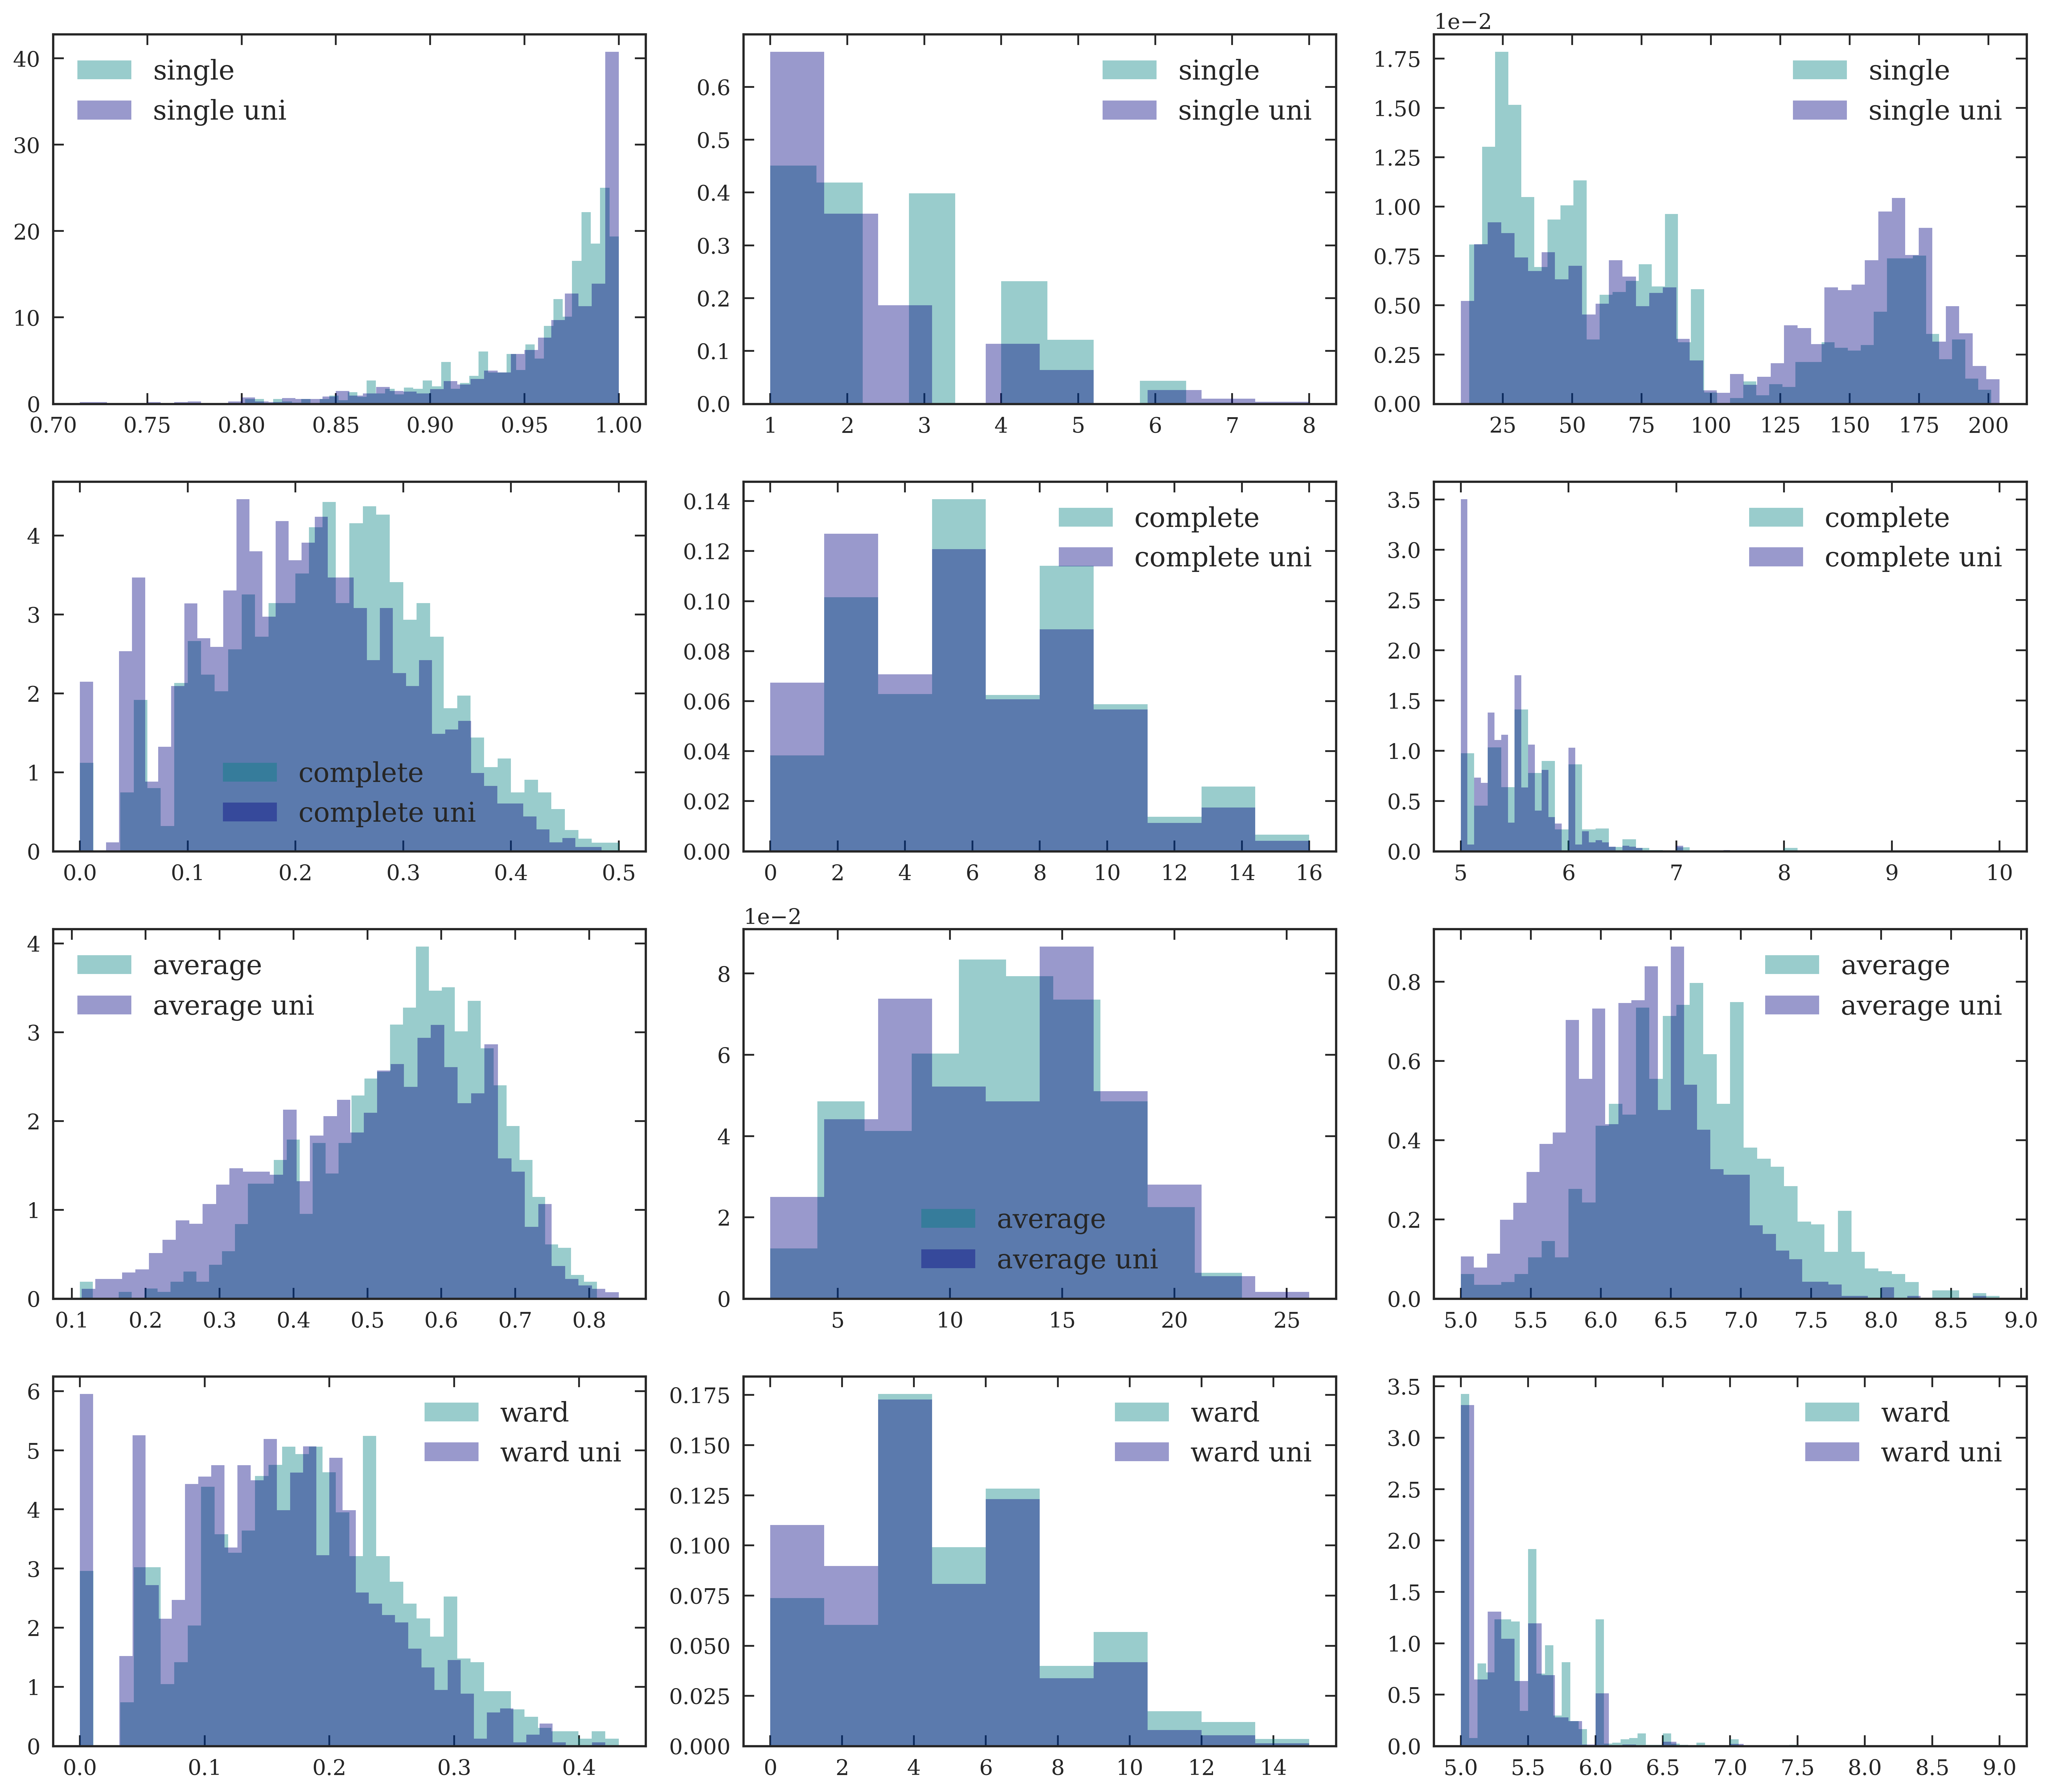

In [98]:
range_list = [(0, 1), (0, 30), (2, 20)]
nbins_list = [80, range_list[1][1] - range_list[1][0], 80]
nbins_list = [40,10,40]
fig, ax = plt.subplots(nrows = len(linkage_list), ncols=3, figsize=(16,14))

for i in range(3):

    for j, linkage in enumerate(linkage_list):
        ax[j,i].hist(cl_dict[linkage][:, 1 + i].flatten(), lw=2, bins=nbins_list[i], \
                histtype='stepfilled', alpha=.4, label = f'{linkage}', density=True)
        ax[j,i].hist(cl_dict_uni[linkage][:, 1 + i].flatten(), lw=2, bins=nbins_list[i], \
                histtype='stepfilled', alpha=.4, label = f'{linkage} uni', density=True)
    #axx[].set_title(linkage_list[i])
        ax[j,i].legend()
   # axx.hist(cl_dict[linkage_list[i]][:, 1 + i].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], \
    #        histtype='stepfilled', alpha=.7, label = f'{cl_dict_keys[i]}', density=True)


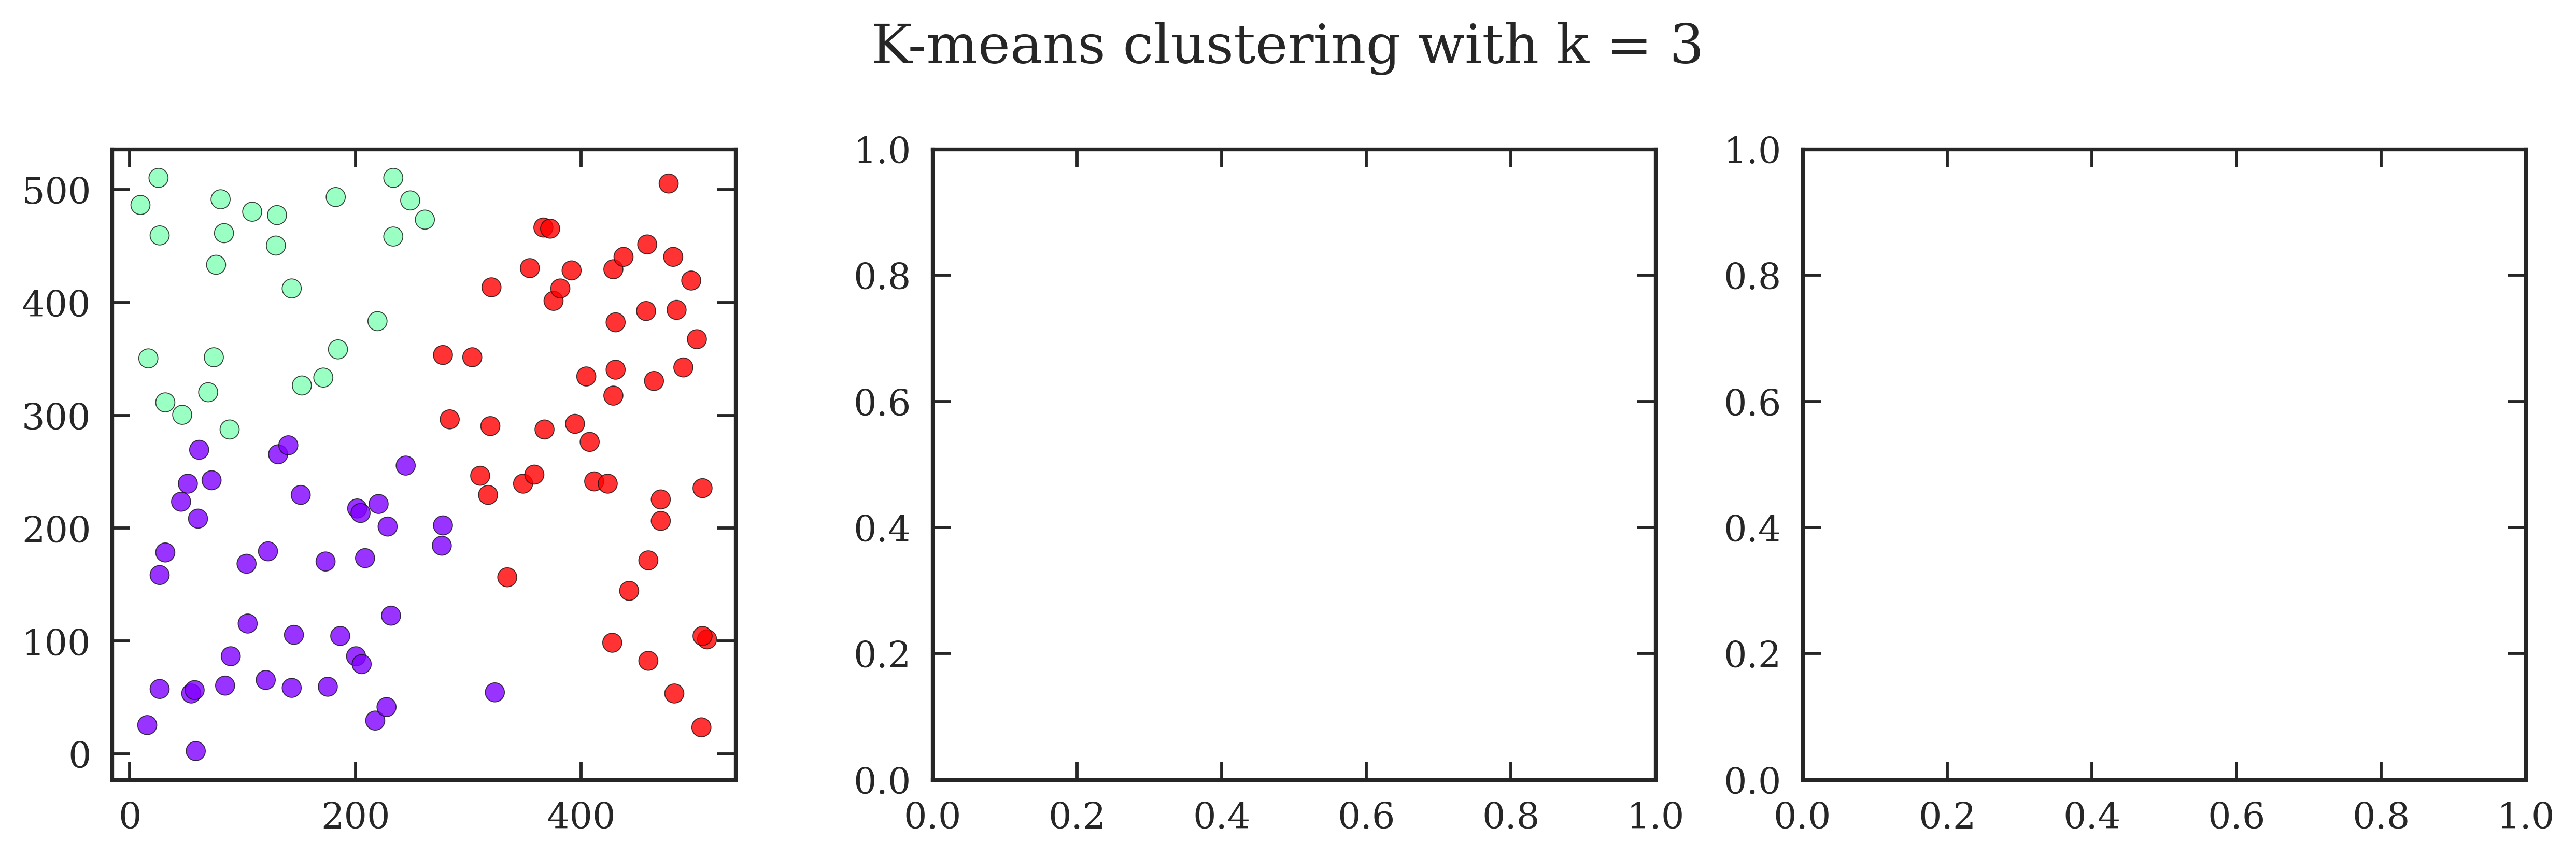

In [32]:
frame_idx = 12
def_arr = get_defect_arr_from_frame(defect_positions[frame_idx])

cst = AgglomerativeClustering(**method_kwargs)


# Set number of clusters
nclusters = 3
# Initialize K-means algorithm with 4 clusters
# This initializes a KMeans object that will segment the data into 17 clusters
kmeans = KMeans(n_clusters=nclusters, n_init = 50,)
# Fit the K-means algorithm to the scaled data
# The fit method computes centroids of 4 clusters in the scaled feature space

with warnings.catch_warnings(): # ignore warnings
    warnings.simplefilter("ignore", category=UserWarning)
    kmeans.fit(def_arr)

# Retrieve the cluster labels
# After fitting, each instance in df_scaled is assigned to one of the 17 clusters
labels = kmeans.labels_
# Shift labels
shifted_labels = labels + 1

# Create a 2D scatter plots to visualize the clustering
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.suptitle(f"K-means clustering with k = {nclusters}", fontsize=18)

ax[0].scatter(def_arr[:, 0], def_arr[:, 1], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
#ax[1].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 2], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
#ax[2].scatter(df_scaled.iloc[:, 1], df_scaled.iloc[:, 2], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
ax[0].set_aspect('equal')   
#ax[0].set(xlabel = features[0], ylabel = features[1])
#ax[1].set(xlabel = features[0], ylabel = features[2])
#ax[2].set(xlabel = features[1], ylabel = features[2])
fig.tight_layout();

In [ ]:
# ignore warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Use the quick method and immediately show the figure (k is the number of clusters)
    metric_list = ['distortion', 'silhouette', 'calinski_harabasz']

  
    kelbow_visualizer(KMeans(random_state=42, n_init=25), def_arr, metric=metric_list[0], k=(1,30))
    kelbow_visualizer(KMeans(random_state=42, n_init=25), def_arr, metric=metric_list[1], k=(2,30))
    kelbow_visualizer(KMeans(random_state=42, n_init=25), def_arr, metric=metric_list[2], k=(2,30))


In [ ]:

rm_list = []

Nclusters = 250
Ncmin = 1
Nframes = 1501
Ndefects = 0


method_list = ['single', 'complete', 'average', 'ward']

for i, input in enumerate(os.listdir(d_cluster['path'])):
    path = os.path.join(d_cluster['path'], input)
    if i == 0:

        print(f'Analyzing {input}')
        # Load data
        
        for file in os.listdir(path):
            if file.startswith('labels'):
                rm = int(file.split('rm')[-1].split('.')[0])
                if 2 < rm < 150:
                    rm_list.append(int(file.split('rm')[-1].split('.')[0]))

        cluster_arr = np.nan * np.zeros([Nframes, Nclusters - Ncmin, len(rm_list), len(os.listdir(d_cluster['path']))])
        num_clusters = np.zeros([Nframes, len(rm_list), len(os.listdir(d_cluster['path']))])

    with open(os.path.join(path, 'defect_positions.pkl'), 'rb') as f:
        defect_positions = pickle.load(f)

    for k, dist in enumerate(rm_list):
        with open(os.path.join(path, f'labels_rm{dist}.pkl'), 'rb') as f:
            labels = pickle.load(f)
        for j, frame in enumerate(labels):

            if k == 0:
                Ndefects += len(defect_positions[j])

            unique, counts = np.unique(frame, return_counts=True)
            valid_clusters_mask = (counts >= Ncmin)
            num_clusters[j, k, i] = len(unique[valid_clusters_mask])

            # count the number of clusters of each size
            cluster_sizes, cluster_counts = np.unique(counts[valid_clusters_mask], return_counts=True)

            cutoff_mask = (cluster_sizes > Nclusters - 1)
            count_upper  = cutoff_mask.sum()

            cluster_arr[j, cluster_sizes[~cutoff_mask], k, i] = cluster_counts[~cutoff_mask]
            cluster_arr[j, -1, k, i] = count_upper


cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
cluster_arr_std = np.nanstd(cluster_arr, axis = (0,-1)) #/ np.sqrt(cluster_arr.shape[0]*cluster_arr.shape[1])

num_cluster_av = np.mean(num_clusters, axis = (0,-1))
num_cluster_std = np.std(num_clusters, axis = (0,-1))/np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])

In [4]:

rm_list = []

Nclusters = 250
Ncmin = 1
Nframes = 1501
Ndefects = 0
for i, input in enumerate(os.listdir(d_cluster['path'])):
    path = os.path.join(d_cluster['path'], input)
    if i == 0:

        print(f'Analyzing {input}')
        # Load data
        
        for file in os.listdir(path):
            if file.startswith('labels'):
                rm = int(file.split('rm')[-1].split('.')[0])
                if 2 < rm < 150:
                    rm_list.append(int(file.split('rm')[-1].split('.')[0]))

        cluster_arr = np.nan * np.zeros([Nframes, Nclusters - Ncmin, len(rm_list), len(os.listdir(d_cluster['path']))])
        num_clusters = np.zeros([Nframes, len(rm_list), len(os.listdir(d_cluster['path']))])

    with open(os.path.join(path, 'defect_positions.pkl'), 'rb') as f:
        defect_positions = pickle.load(f)

    for k, dist in enumerate(rm_list):
        with open(os.path.join(path, f'labels_rm{dist}.pkl'), 'rb') as f:
            labels = pickle.load(f)
        for j, frame in enumerate(labels):

            if k == 0:
                Ndefects += len(defect_positions[j])

            unique, counts = np.unique(frame, return_counts=True)
            valid_clusters_mask = (counts >= Ncmin)
            num_clusters[j, k, i] = len(unique[valid_clusters_mask])

            # count the number of clusters of each size
            cluster_sizes, cluster_counts = np.unique(counts[valid_clusters_mask], return_counts=True)

            cutoff_mask = (cluster_sizes > Nclusters - 1)
            count_upper  = cutoff_mask.sum()

            cluster_arr[j, cluster_sizes[~cutoff_mask], k, i] = cluster_counts[~cutoff_mask]
            cluster_arr[j, -1, k, i] = count_upper


cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
cluster_arr_std = np.nanstd(cluster_arr, axis = (0,-1)) #/ np.sqrt(cluster_arr.shape[0]*cluster_arr.shape[1])

num_cluster_av = np.mean(num_clusters, axis = (0,-1))
num_cluster_std = np.std(num_clusters, axis = (0,-1))/np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])

Analyzing zeta_0.022_counter_0


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_17612\1887257081.py:48: RuntimeWarning: Mean of empty slice
  cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [24]:
Nupper = 101 - Ncmin

ff = 0

Nmembers_arr = np.nansum(cluster_arr[ff:, :, :, :], axis=(0,-1)) * np.arange(Ncmin, Nclusters)[:, None] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_above = Nmembers_arr[Nupper:,:].sum(axis = 0)
Nmembers_arr = Nmembers_arr[:Nupper,:] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_arr[Nupper - 1,:] += Nmembers_above

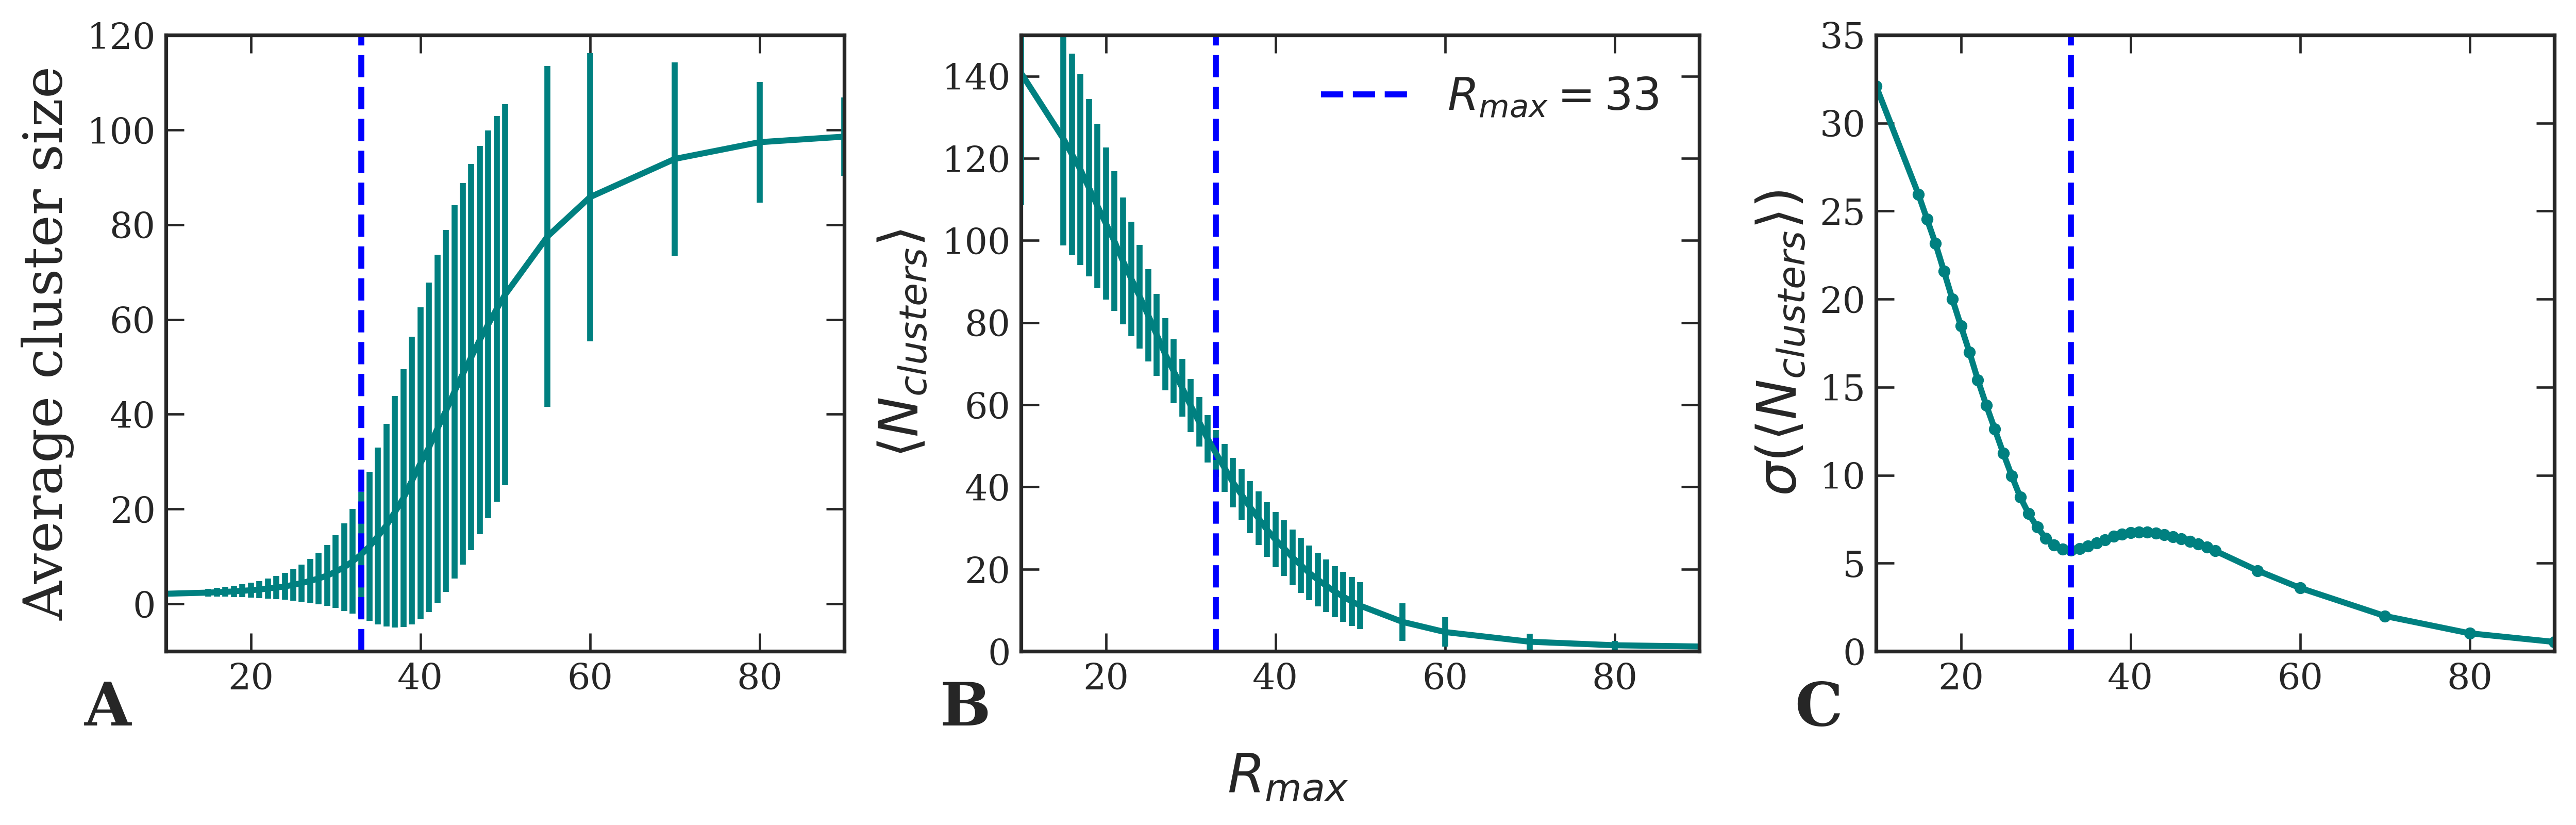

In [25]:
fig, ax = plt.subplots(nrows = 1,ncols=3, figsize=(12, 4.))
ax = ax.flatten()
Nmembers = Nmembers_arr[:, :] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin) [:, None]
av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)[:,None], axis=0) / Nmembers.sum(axis=0)
std_cluster_size = np.sqrt(np.sum(Nmembers * ((np.arange(Ncmin, Nupper + Ncmin)[:,None] - av_cluster_size[None,:])**2), axis=0)\
                            / Nmembers.sum(axis=0),)


dy = np.diff(av_cluster_size)
dx = np.diff(rm_list)
nc_std = num_cluster_std *np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])
min_idx = np.argwhere(np.diff(nc_std) > 0)[0][0] 


ax[0].errorbar(rm_list, av_cluster_size, std_cluster_size, label = 'Average cluster size')
ax[1].errorbar(rm_list, num_cluster_av, nc_std,)
ax[2].plot(rm_list, nc_std, '.-')

for n, axx in enumerate(ax):
    ax[n].text(-0.12, -.12, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')

fig.supxlabel(r'$R_{max}$', y=0.06)
m_list = [120, 150, 35]
ylim_list = [(-10,120), (0, 150), (0, 35)]
ylabel_list = ['Average cluster size', r'$\langle N_{clusters} \rangle$', r'$\sigma(\langle N_{clusters} \rangle)$']

for j, axx in enumerate(ax):
    axx.set_ylim(ylim_list[j])
    axx.set_xlim([10,90])
    axx.set_ylabel(ylabel_list[j])
    axx.set_xticks(np.arange(20,100,20), np.arange(20,100,20))
    axx.vlines(rm_list[min_idx], ylim_list[j][0], m_list[j], label = r'$R_{max} = 33$', linestyles = 'dashed', color = 'b')
ax[1].legend()
plt.tight_layout()  

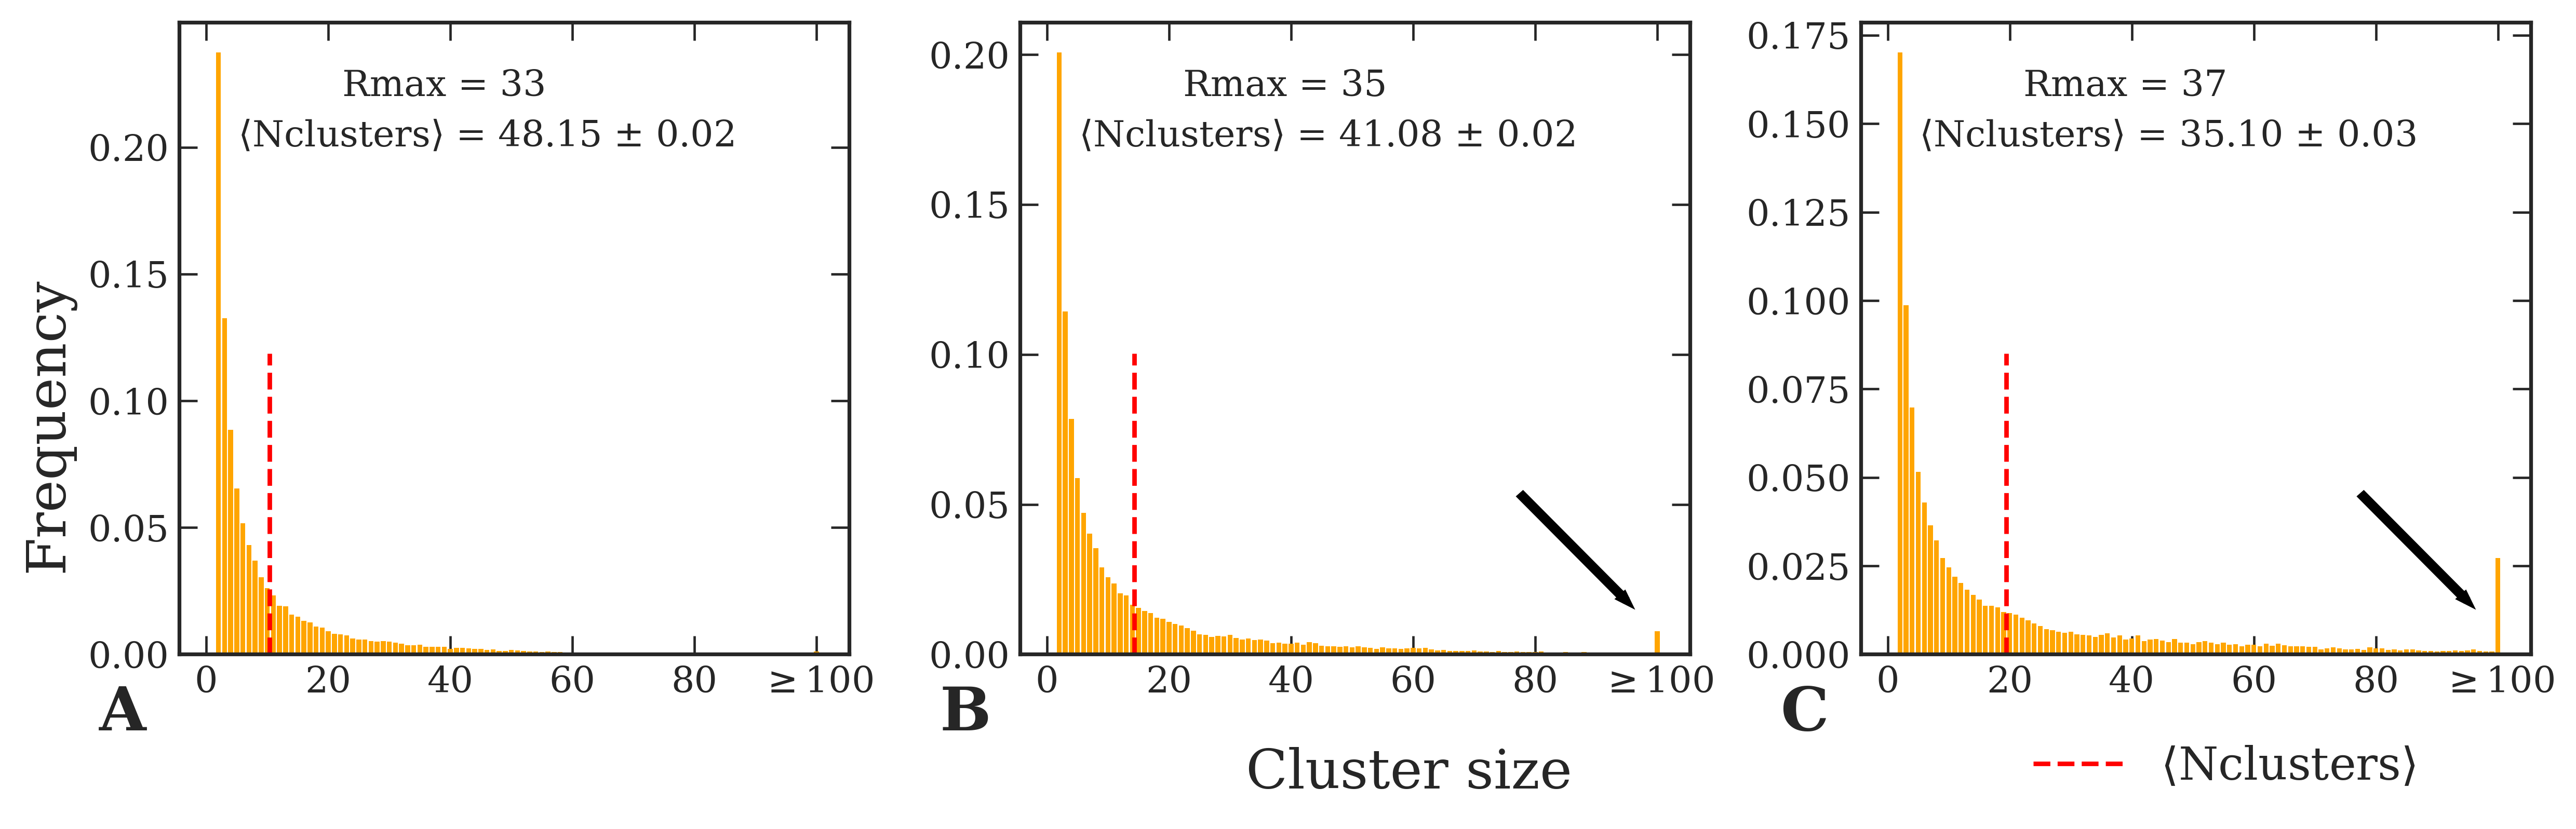

In [49]:
ncols = 3
rm_res = rm_list[16:28]

rm_res = [33, 35, 37]
nrows = int(np.ceil(len(rm_res)/ncols))


fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(12, 4))
#fig, ax = plt.subplot_mosaic("AB;CD", figsize=(8, 6))
ax = ax.flatten()
for i, dist in enumerate(rm_res):
    idx = rm_list.index(dist)

    Nmembers = Nmembers_arr[:, idx] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

    cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin)
    av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)) / Nmembers.sum()
    std_cluster_size = np.sqrt(np.sum(Nmembers * (np.arange(Ncmin, Nupper + Ncmin) - av_cluster_size)**2) / Nmembers.sum())
    
    max_count = np.max(Nmembers / Nmembers.sum())
    label = rf'$\langle$Nclusters$\rangle$' if i == 0 else None
    ax[i].vlines(av_cluster_size, 0, max_count/2, color = 'r', label = label, linestyle='--',lw=1.5)#, label = f'Nclusters = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}')
    ax[i].bar(np.arange(Ncmin, Nupper + Ncmin), Nmembers / Nmembers.sum(), color='orange') #, yerr = cluster_arr_std[:,idx],)

    ax[i].text(0.4575, 0.82, rf'$\langle$Nclusters$\rangle$ = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}', \
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)
    ax[i].text(0.395, 0.9, f'Rmax = {dist}', \
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)

    ax[i].set(xticks=np.arange(0, 101, 20), xticklabels=[*np.arange(0, 101, 20)[:-1], r'$\geq$100'])

for n, axx in enumerate(ax):
    ax[n].text(-0.12, -.12, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')
    if n > 0:
        ax[n].arrow(0.75, 0.25, .15, -.16, transform=ax[n].transAxes, lw = 3)
fig.supxlabel('Cluster size', x = 0.55, y=0.07)#25)
fig.supylabel('Frequency', x = 0.02);
fig.legend(ncol = 1, bbox_to_anchor = (0.95, 0.18))
fig.tight_layout()